In [3]:
import csv
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, linear_model, tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import scipy.sparse
from sklearn.decomposition import PCA
import sklearn
from scipy.sparse import csr_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
import math
import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load("nl_core_news_lg")

In [6]:
filepath = 'C:\\Users\\yytimmer\OneDrive - ugentbe\\Bureaublad\\Doctoraat\\Papers\\News updates\\Predictive model\\Dataset\\'

#read data
my_data = pd.read_csv(filepath + 'input_data_model_subj_1.csv', quotechar='"', delimiter=',')
my_train_data = pd.read_csv(filepath + 'input_data_model_subj_train_1.csv', quotechar='"', delimiter=',')
my_test_data = pd.read_csv(filepath + 'input_data_model_subj_test_1.csv', quotechar='"', delimiter=',')

my_train_data['test'] = False
my_test_data['test'] = True
my_data = my_train_data.append(my_test_data, ignore_index = True)

#fill up NULL values in the original data with 0
my_data['fraction_total_changed_intro_original'].fillna(0, inplace=True) 
my_data['fraction_total_changed_intro_new'].fillna(0, inplace=True) 
my_data['fraction_total_changed_text_original'].fillna(0, inplace=True) 
my_data['fraction_total_changed_text_new'].fillna(0, inplace=True) 
my_data['original_changed_text'].fillna('', inplace=True) 
my_data['new_changed_text'].fillna('', inplace=True) 
my_data['topic'].fillna('other', inplace=True) 

In [7]:
#show distribution of positive and negative samples
print(my_data['type'].value_counts())

False    20785
True       344
Name: type, dtype: int64


In [8]:
#prepare the features to be inputted to the model

my_data['original_time'] = pd.to_datetime(my_data['original_time'], format='%Y-%m-%d %H:%M:%S.%f')
my_data['new_time'] = pd.to_datetime(my_data['new_time'], format='%Y-%m-%d %H:%M:%S.%f')
my_data['first_time'] = pd.to_datetime(my_data['first_time'], format='%Y-%m-%d %H:%M:%S.%f')

my_data['weekday_original'] = my_data['original_time'].dt.weekday
my_data['hour_original'] = my_data['original_time'].dt.hour
my_data['weekday_new'] = my_data['new_time'].dt.weekday
my_data['hour_new'] = my_data['new_time'].dt.hour
my_data['weekday_first'] = my_data['first_time'].dt.weekday
my_data['hour_first'] = my_data['first_time'].dt.hour

data_to_encode = my_data[['newspaper', 'topic', 'textpart', 'first_wordtype', 'last_wordtype']]
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe_data = pd.DataFrame(ohe.fit_transform(data_to_encode))

normalized_continuous_array = ['weekday_original', 'weekday_new', 'hour_original', 'hour_new',
    'length_original', 'length_new', 'max_version_number', 
                               'version_number_progress',
                                 'dates_difference', 
                               'time_difference', 'original_title_length', 'original_intro_length',
               'original_text_length', 'new_title_length', 'new_intro_length', 'new_text_length', 
                               'fraction_original_title_changed', 'fraction_new_title_changed',
              'fraction_original_intro_changed', 'fraction_new_intro_changed',
              'fraction_original_text_changed', 'fraction_new_text_changed', 
                                 'original_changed_fraction_text_part', 'new_changed_fraction_text_part', 
                'levenshtein_maximalized',
                               'nr_insert_max', 'nr_delete_max', 'nr_replace_max',
              'levenshtein_minimalized',
                               'nr_insert_min', 'nr_delete_min', 'nr_replace_min',
                               'jaccard', 'capitalized_equality',
    'seqratio', 'text_overlap_original', 'text_overlap_new',
              'stop_words_ratio',
                               'fraction_total_changed_original', 'fraction_total_changed_new',
                            'fraction_total_changed_title_original', 'fraction_total_changed_title_new',
              'fraction_total_changed_intro_original', 'fraction_total_changed_intro_new',
              'fraction_total_changed_text_original', 'fraction_total_changed_text_new',
            'ent_original', 'original_token_length', 'adv_orig', 'noun_orig', 'point_orig', 'comma_orig',
              'accent_orig', 'haakje_orig', 'doublepoint_orig', 'hyphen_orig', 'threepoints_orig', 'punct_orig', 'x_orig', 'propn_orig',
              'pron_orig', 'det_orig', 'sconj_orig', 'space_orig', 'sym_orig', 'num_orig', 'adp_orig',
              'intj_orig', 'aux_orig', 'inf_orig', 'pv_verl_ev_orig', 'pv_verl_mv_orig', 'pv_tgw_ev_orig', 'pv_tgw_mv_orig',
                'od_prenom_orig', 'od_nom_orig', 'od_postnom_orig', 'od_vrij_orig', 'vd_vrij_orig', 'vd_prenom_orig', 
              'vd_postnom_orig', 'vd_nom_orig', 'verb_orig', 'cconj_orig', 'adj_sup_orig', 'adj_comp_orig', 'adj_basis_orig',
              'ent_new', 'new_token_length', 'adv_new', 'noun_new', 'point_new', 'comma_new',
              'accent_new', 'haakje_new', 'doublepoint_new', 'hyphen_new', 'threepoints_new', 'punct_new', 'x_new', 'propn_new',
              'pron_new', 'det_new', 'sconj_new', 'space_new', 'sym_new', 'num_new', 'adp_new',
              'intj_new', 'aux_new', 'inf_new', 'pv_verl_ev_new', 'pv_verl_mv_new', 'pv_tgw_ev_new', 'pv_tgw_mv_new',
                'od_prenom_new', 'od_nom_new', 'od_postnom_new', 'od_vrij_new', 'vd_vrij_new', 'vd_prenom_new', 
              'vd_postnom_new', 'vd_nom_new', 'verb_new', 'cconj_new', 'adj_sup_new', 'adj_comp_new', 'adj_basis_new',  
              'orginal_spelling_ok', 'new_spelling_ok', 'number_comparison', 'changed_position',
                               'nr_red_parts', 'nr_green_parts', 'orig_part_of_new', 'new_part_of_orig',
                               'one_edit_change', 'sentence_sim', 'diff_sim', 
                               'doubt_words_orig', 'doubt_words_new',
                               'doubt_words_total',
                               'negation_original',
                               'negation_new', 'temporary',
              'colors', 'days', 'currencies', 'months', 'winds', 'states', 'countries', 'cities', 'belgian', 'nationality',
              'date_diff', 'person_diff', 'nr_full_sentences_original', 'nr_full_sentences_new',
                               'entity_present_in_original', 'entity_present_in_new'
                              ]


boolean_features = ['double_word', 'equal_after_subst', 'globally_equal_after_subst']
text_array = ['original_changed_text', 'new_changed_text']

text_df = my_data[text_array].fillna('')
my_data = my_data.replace(np.inf, 0)

#normalize all continuous variables before continuing
normalized_continuous = (my_data[normalized_continuous_array] - my_data[normalized_continuous_array].min())/(my_data[normalized_continuous_array].max() - my_data[normalized_continuous_array].min() + 0.01)

boolean = my_data[boolean_features]

le = preprocessing.LabelEncoder()
labels = pd.DataFrame({'labels': le.fit_transform(my_data['type'])})

test = pd.DataFrame({'test': my_data['test']})

all_data = pd.concat([ohe_data, normalized_continuous, boolean, text_df, labels, test], axis=1)

In [9]:
#split up the training data (80%) and the test data (20%)
train_data = all_data[all_data["test"]==False].iloc[:, :-1]
test_data = all_data[all_data["test"]==True].iloc[:, :-1]

In [10]:
#verify number of features needed for 95% threshold using LSA

#transform textual data present in the atomic changes (in the attributes 'original_changed_text' and 'new_changed_text')
#into TF-IDF features such that we have all initial features that would be used in the model
vectorizer_original = TfidfVectorizer()
vectorizer_new = TfidfVectorizer()

column_transformer = ColumnTransformer(
    [('tfidf_original', vectorizer_original, 'original_changed_text'), 
    ('tfidf_new', vectorizer_new, 'new_changed_text')],
    remainder='passthrough')

temp_train_data = column_transformer.fit_transform(train_data)

truncatedsvd = TruncatedSVD(n_components=1850)
truncatedsvd.fit(temp_train_data)

print(truncatedsvd.explained_variance_ratio_.sum())

0.9506231501742644


In [11]:
#define f2 scorer
def fbeta_score(y_true, y_pred):
    return metrics.fbeta_score(y_true, y_pred, beta=2)

In [14]:
#divide the training data into five different folds in order to apply stratified k-fold cross validation
train_data["kfold"] = -1
train_data = train_data.sample(frac=1).reset_index(drop=True)
kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X = train_data, y=train_data['labels'].values)):
    train_data.loc[v_, 'kfold'] = f

In [15]:
#function that implements grid search for hyperparameter optimization by selecting the optimization algorithm
#and parameters accordingly
def grid(x_train, y_train, x_test, y_test):
    
    #Grid Search Model
    #clf = tree.DecisionTreeClassifier(random_state=0)
    clf = linear_model.LogisticRegression(class_weight='balanced', max_iter=1000)
    #clf = LinearSVC(class_weight="balanced", random_state=0)
    
    sampling_strategy_o = 0.32
    pipe = imb_pipeline([
                ('tfidf', column_transformer),
                ('over', RandomOverSampler(sampling_strategy=sampling_strategy_o, random_state=0)),
                ('classify', clf)
        ])


    param_grid = {"classify__C":[0.001, 0.01, 0.1, 1.0, 10, 100], "classify__penalty":["l1", "l2", 'elasticnet'],
                 "classify__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    #param_grid = {"classify__criterion": ['entropy', gini', 'log_loss'], 
    #"classify__max_depth": [2,4,6,8,10,12, 14, 16, 18, 20, 22, 24, 26, 28, 30]}
    #param_grid = {"classify__loss": ['hinge', 'squared_hinge'],
    #"classify__alpha":[ 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], "classify__penalty":["l1", l2"]}
    
    scorer = metrics.make_scorer(fbeta_score, greater_is_better=True, needs_threshold=False)

    model = model_selection.GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scorer,
    refit=True,
    verbose=10,
    cv=5)
    
    model.fit(x_train, y_train)
    
    print("Best score: " + str(model.best_score_))
    print("Best parameter set: ")
    best_parameters = model.best_estimator_.get_params()
    
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    best_model = model.best_estimator_
    best_model.fit(x_train, y_train)
    preds = best_model.predict(x_test)
    
    score = metrics.fbeta_score(y_test, preds, beta=2)
    print("Test score: " + str(score))

In [16]:
#perform grid search
x_train = train_data.drop('labels', axis=1).drop('kfold', axis=1)
y_train = train_data['labels'].values

x_test = test_data.drop('labels', axis=1)
y_test = test_data['labels'].values

grid(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg
[CV 1/5; 1/30] END classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg;, score=0.136 total time=   1.7s
[CV 2/5; 1/30] START classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg
[CV 2/5; 1/30] END classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg;, score=0.129 total time=   1.5s
[CV 3/5; 1/30] START classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg
[CV 3/5; 1/30] END classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg;, score=0.121 total time=   1.7s
[CV 4/5; 1/30] START classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg
[CV 4/5; 1/30] END classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg;, score=0.137 total time=   1.7s
[CV 5/5; 1/30] START classify__C=0.001, classify__penalty=l2, classify__solver=newton-cg
[CV 5/5; 1/30

[CV 1/5; 9/30] END classify__C=0.01, classify__penalty=l2, classify__solver=sag;, score=0.175 total time=   7.1s
[CV 2/5; 9/30] START classify__C=0.01, classify__penalty=l2, classify__solver=sag
[CV 2/5; 9/30] END classify__C=0.01, classify__penalty=l2, classify__solver=sag;, score=0.166 total time=   7.7s
[CV 3/5; 9/30] START classify__C=0.01, classify__penalty=l2, classify__solver=sag
[CV 3/5; 9/30] END classify__C=0.01, classify__penalty=l2, classify__solver=sag;, score=0.146 total time=   7.4s
[CV 4/5; 9/30] START classify__C=0.01, classify__penalty=l2, classify__solver=sag
[CV 4/5; 9/30] END classify__C=0.01, classify__penalty=l2, classify__solver=sag;, score=0.174 total time=   7.4s
[CV 5/5; 9/30] START classify__C=0.01, classify__penalty=l2, classify__solver=sag
[CV 5/5; 9/30] END classify__C=0.01, classify__penalty=l2, classify__solver=sag;, score=0.149 total time=   7.0s
[CV 1/5; 10/30] START classify__C=0.01, classify__penalty=l2, classify__solver=saga
[CV 1/5; 10/30] END cla

[CV 2/5; 17/30] END classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs;, score=0.190 total time=   3.9s
[CV 3/5; 17/30] START classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs
[CV 3/5; 17/30] END classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs;, score=0.215 total time=   4.2s
[CV 4/5; 17/30] START classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs
[CV 4/5; 17/30] END classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs;, score=0.291 total time=   4.0s
[CV 5/5; 17/30] START classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs
[CV 5/5; 17/30] END classify__C=1.0, classify__penalty=l2, classify__solver=lbfgs;, score=0.240 total time=   3.7s
[CV 1/5; 18/30] START classify__C=1.0, classify__penalty=l2, classify__solver=liblinear
[CV 1/5; 18/30] END classify__C=1.0, classify__penalty=l2, classify__solver=liblinear;, score=0.186 total time=   1.5s
[CV 2/5; 18/30] START classify__C=1.0, classify__penalty=l2, classify__solver=lib

[CV 4/5; 25/30] END classify__C=10, classify__penalty=l2, classify__solver=saga;, score=0.225 total time=  13.6s
[CV 5/5; 25/30] START classify__C=10, classify__penalty=l2, classify__solver=saga
[CV 5/5; 25/30] END classify__C=10, classify__penalty=l2, classify__solver=saga;, score=0.228 total time=  14.7s
[CV 1/5; 26/30] START classify__C=100, classify__penalty=l2, classify__solver=newton-cg
[CV 1/5; 26/30] END classify__C=100, classify__penalty=l2, classify__solver=newton-cg;, score=0.181 total time=   4.3s
[CV 2/5; 26/30] START classify__C=100, classify__penalty=l2, classify__solver=newton-cg
[CV 2/5; 26/30] END classify__C=100, classify__penalty=l2, classify__solver=newton-cg;, score=0.167 total time=   4.2s
[CV 3/5; 26/30] START classify__C=100, classify__penalty=l2, classify__solver=newton-cg
[CV 3/5; 26/30] END classify__C=100, classify__penalty=l2, classify__solver=newton-cg;, score=0.181 total time=   4.8s
[CV 4/5; 26/30] START classify__C=100, classify__penalty=l2, classify__

In [17]:
#function for the execution of the best model that was finally obtained
def run(fold, df, clf, x_valid_total, y_valid_total, preds_total_valid):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    x_train = df_train.drop('labels', axis=1).drop('kfold', axis=1)
    y_train = df_train['labels'].values
    
    x_valid = df_valid.drop('labels', axis=1).drop('kfold', axis=1)
    y_valid = df_valid['labels'].values

    clf.fit(x_train, y_train)
    
    preds_train = clf.predict(x_train)
    preds_valid = clf.predict(x_valid)

    score_train = metrics.fbeta_score(y_train, preds_train, beta=2)
    
    score_valid = metrics.fbeta_score(y_valid, preds_valid, beta=2)
    print("Validation Fold: " + str(fold) + ": " + str(score_valid))
    
    if fold == 0:
        x_valid_total = x_valid
        y_valid_total = y_valid
        preds_total_valid = preds_valid
        
    else:
        x_valid_total = np.concatenate((x_valid_total, x_valid), axis=0)
        y_valid_total = np.concatenate((y_valid_total, y_valid), axis=None)
        preds_total_valid = np.concatenate((preds_total_valid, preds_valid), axis=None)
    
    return score_valid, x_valid_total, y_valid_total, preds_total_valid

In [18]:
#execute the best model that was found using grid search
x_valid_total = None
y_valid_total = None
preds_total = None

folds = 5
#clf = tree.DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=10)
clf = linear_model.LogisticRegression(class_weight='balanced', solver='sag', C=1, penalty='l2')
#clf2 = svm.LinearSVC(class_weight='balanced', C=0.01, loss='squared_hinge')

sampling_strategy_o = 0.32
pipe = imb_pipeline([
                ('tfidf', column_transformer),
                ('over', RandomOverSampler(sampling_strategy=sampling_strategy_o, random_state=0)),
                ('classify', clf)
        ])
avg = 0
for i in range(0, folds):
    run_fold = run(i, train_data, pipe, x_valid_total, y_valid_total, preds_total)
    avg = avg + run_fold[0]
    x_valid_total = run_fold[1]
    y_valid_total = run_fold[2]
    preds_total = run_fold[3]
    
avg = avg/folds
print("Average fold score: " + str(avg))

Validation Fold: 0: 0.18691588785046728
Validation Fold: 1: 0.2070063694267516
Validation Fold: 2: 0.2259036144578313
Validation Fold: 3: 0.2923076923076924
Validation Fold: 4: 0.24024024024024024
Average fold score: 0.23047476085659654


In [19]:
#determine score on test set and averaged out over validation and test set
x_train = train_data.drop('labels', axis=1).drop('kfold', axis=1)
y_train = train_data['labels'].values

x_test = test_data.drop('labels', axis=1)
y_test = test_data['labels'].values

pipe.fit(x_train, y_train)
preds = pipe.predict(x_test)

x_valid_total = np.concatenate((x_valid_total, x_test), axis=0)
y_valid_total = np.concatenate((y_valid_total, y_test), axis=None)
preds_total = np.concatenate((preds_total, preds), axis=None)

score = metrics.fbeta_score(y_test, preds, beta=2)
print("Test score: " + str(score))

print("avg_score: " + str(0.8*avg + 0.2*score))

Test score: 0.25000000000000006
avg_score: 0.23437980868527727


Confusion matrix, without normalization
[[4034  123]
 [  48   21]]
Normalized confusion matrix
[[0.97041135 0.02958865]
 [0.69565217 0.30434783]]


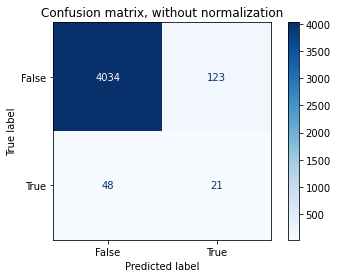

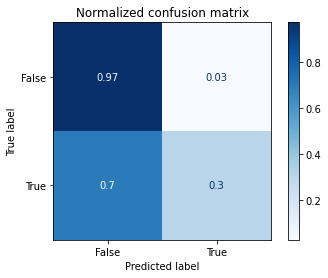

In [21]:
# Plot confusion matrix obtained by the best model
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        pipe,
        pd. DataFrame(x_test),
        y_test,
        display_labels=le.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )

    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)